## Comparing annotations

**TODO: add histograms, compare proportions**

Reloading results: 

In [39]:
whole_image_annotation = {n: {} for n in names}  # for each image: dict mapping annotated formulas to their proportions
average_spectrum_annotation = {n: {} for n in names}
for i,n in enumerate(names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)
        annotation = [l.strip().split('\t') for l in h if l.strip()]
        for l in annotation:
            whole_image_annotation[n][l[0]] = float(l[2])
    with open(n + '_average_spectrum_annotation_results.tsv') as h:
        next(h)
        annotation = [l.strip().split('\t') for l in h if l.strip()]
        for l in annotation:
            average_spectrum_annotation[n][l[0]] = float(l[2])

In [40]:
for n in names:
    print(n, 'Whole image:', len(whole_image_annotation[n]), 
          'Average spectrum:', len(average_spectrum_annotation[n]), 
          'Both:', len(set(whole_image_annotation[n]).intersection(set(average_spectrum_annotation[n]))))

cerebellum Whole image: 81 Average spectrum: 75 Both: 66
bladder Whole image: 44 Average spectrum: 42 Both: 32


#### The overall correlation between the results of the two annotation strategies:

In [41]:
joint_formula_lists = {n: {} for n in names}
proportion_vectors = {n: {} for n in names}
for i,n in enumerate(names): 
    all_formulas = list(set(whole_image_annotation[n]) | set(average_spectrum_annotation[n]))
    joint_formula_lists[n] = all_formulas
    proportion_vectors[n]['average'] = [average_spectrum_annotation[n][f] if f in average_spectrum_annotation[n] else 0. for f in all_formulas]
    proportion_vectors[n]['whole'] = [whole_image_annotation[n][f] if f in whole_image_annotation[n] else 0. for f in all_formulas]

<IPython.core.display.Javascript object>


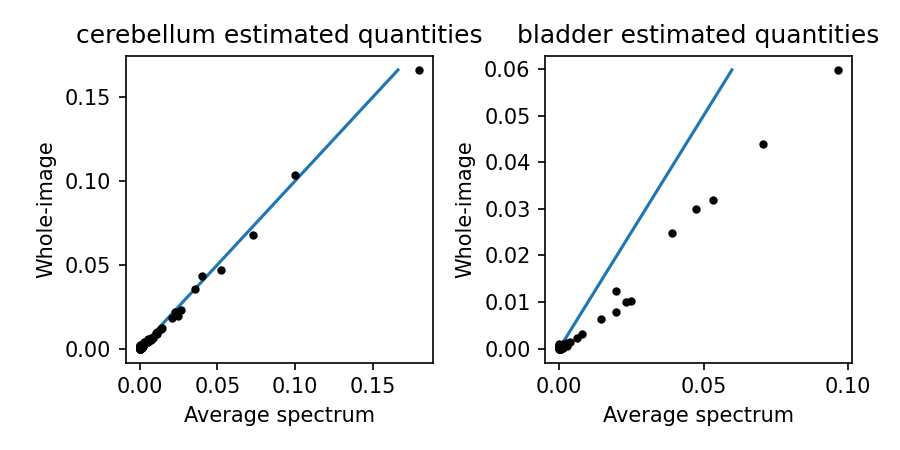

In [42]:
plt.figure(figsize=(6,3))
for i, n in enumerate(names):
    plt.subplot(121+i)
    plt.title(n + ' estimated quantities')
    plt.plot([0, max(proportion_vectors[n]['whole'])], [0, max(proportion_vectors[n]['whole'])])
    plt.plot(proportion_vectors[n]['average'], proportion_vectors[n]['whole'], 'k.')
    
    plt.ylabel('Whole-image')
    plt.xlabel('Average spectrum')
plt.tight_layout()

Check the correlation of annotations (*after discarding lipids absent in both images*, because they artificially inflate the correlation - this is already done)

In [43]:
for i, n in enumerate(names):
    print('Correlation of estimations in', n, 
          np.corrcoef(proportion_vectors[n]['average'], proportion_vectors[n]['whole'])[0,1])

Correlation of estimations in cerebellum 0.9980026991044272
Correlation of estimations in bladder 0.9948480454533302


In [44]:
np.all(np.array(proportion_vectors[n]['average']) + np.array(proportion_vectors[n]['whole'])>0)

True

#### Differences between the annotations

In [45]:
formulas_in_average = {n: set(average_spectrum_annotation[n]) for n in names}
formulas_in_whole = {n: set(whole_image_annotation[n]) for n in names}
venn_dicts = [{'average, then annotate': formulas_in_average[n], 'annotate, then average': formulas_in_whole[n]} for n in names]

cerebellum


<IPython.core.display.Javascript object>


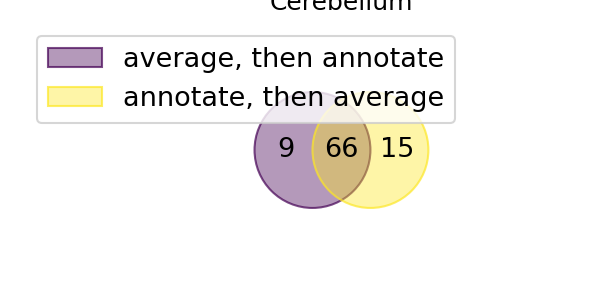

Text(0.5, 1.0, 'Cerebellum')

In [46]:
print(names[0])
venn(venn_dicts[0], figsize=(4,2))
plt.tight_layout()
plt.title('Cerebellum')


bladder


<IPython.core.display.Javascript object>


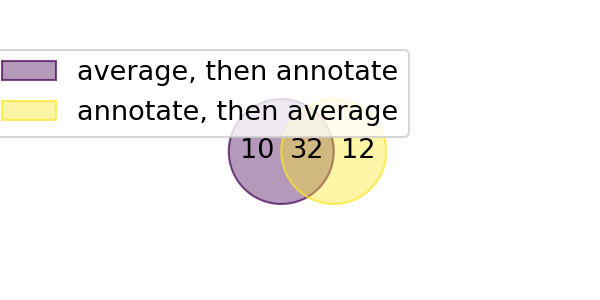

In [47]:
print(names[1])
venn(venn_dicts[1], figsize=(4,2))
plt.show()

Examples of lipids found only when the image was annotated on a per-pixel basis ("annotate -> average" rather than "average -> annotate")

In [53]:
found_only_per_pixel = [sorted([(p, i) for i,p in enumerate(proportions_in_whole[j]) if proportions_in_average[j][i] <=0.0001], reverse=True) for j in range(2)]

In [121]:
found_only_per_pixel = {n: set(whole_image_annotation[n]) - set(average_spectrum_annotation[n]) for n in names}
for n in names:
    sorted_formulas = sorted(found_only_per_pixel[n], key = lambda f: whole_image_annotation[n][f], reverse=True)
    found_only_per_pixel[n] = [(whole_image_annotation[n][f], f, lipid_formulas.index(f)) for f in sorted_formulas]

In [122]:
found_only_per_pixel['cerebellum'][:10]

[(0.0022, 'C38H76NO8P', 915),
 (0.0018, 'C40H75O9P', 923),
 (0.0015, 'C43H85O7P', 619),
 (0.0014, 'C41H83O7P', 285),
 (0.0011, 'C42H82NO11P', 541),
 (0.0006, 'C44H87N2O6P', 929),
 (0.0004, 'C46H82NO8P', 755),
 (0.0002, 'C42H83N2O6P', 212),
 (0.0002, 'C47H76NO8P', 868),
 (0.0001, 'C40H81N2O6P', 866)]

In [69]:
found_only_per_pixel['bladder'][:10]

[(0.001, 'C45H91N2O6P', 809),
 (0.0007, 'C48H91O10P', 437),
 (0.0005, 'C43H85O7P', 619),
 (0.0004, 'C42H81NO10', 34),
 (0.0003, 'C44H85NO10', 1188),
 (0.0003, 'C43H87N2O6P', 410),
 (0.0002, 'C42H85N2O6P', 126),
 (0.0002, 'C46H89O10P', 506),
 (0.0002, 'C40H79O7P', 692),
 (0.0001, 'C42H79NO13', 306)]

Check which lipids are "invisible" in the average spectrum

In [117]:
distances_to_closest_peaks = {}
for i, n in enumerate(names):
    masses_to_check = [lipid_spectra[i].confs[0][0] for p,f,i in found_only_per_pixel[n]]
    av_masses = np.array(average_spectrum_masses[i])
    closest_idx = np.searchsorted(av_masses, masses_to_check, side='left')
    ld = np.abs(av_masses[closest_idx-1] - masses_to_check)
    rd = np.abs(av_masses[closest_idx] - masses_to_check)
    distances_to_closest_peaks[n] = np.min([ld, rd], axis=0)

In [149]:
interesting = {}
for n in names:
    interesting[n] = sorted(zip(distances_to_closest_peaks[n], found_only_per_pixel[n]), reverse=True)
    print(n, interesting[n])

cerebellum [(0.02297889733131342, (0.0001, 'C42H80NO10P', 505)), (0.014758382807599446, (0.0001, 'C47H91N2O6P', 816)), (0.012125924070687688, (0.0001, 'C45H85O8P', 1060)), (0.01091871509390785, (0.0001, 'C38H75N2O6P', 8)), (0.008430548392198034, (0.0004, 'C46H82NO8P', 755)), (0.007148500040329964, (0.0002, 'C47H76NO8P', 868)), (0.006825591007896037, (0.0011, 'C42H82NO11P', 541)), (0.006821673923013805, (0.0001, 'C40H81N2O6P', 866)), (0.006338728839523355, (0.0006, 'C44H87N2O6P', 929)), (0.006175868864488621, (0.0002, 'C42H83N2O6P', 212)), (0.00487585834798665, (0.0014, 'C41H83O7P', 285)), (0.004855237825495351, (0.0015, 'C43H85O7P', 619)), (0.0011010451784159159, (0.0022, 'C38H76NO8P', 915)), (0.0009146141470637303, (0.0018, 'C40H75O9P', 923)), (0.0003599198475967569, (0.0001, 'C48H92NO8P', 623))]
bladder [(0.010591894823733128, (0.0002, 'C40H79O7P', 692)), (0.009142206060460012, (0.0001, 'C46H82NO10P', 1048)), (0.008813950334001674, (0.0004, 'C42H81NO10', 34)), (0.00830959082179561, (

In [128]:
to_check_bladder = 692 # 306
spectrum_hidden_in_bladder = lipid_spectra[to_check_bladder]
print(spectrum_hidden_in_bladder.formula, spectrum_hidden_in_bladder.confs[0][0])

C40H79O7P 741.5200483823301


In [150]:
to_check_cerebellum = 816 # 1144
spectrum_hidden_in_cerebellum = lipid_spectra[to_check_cerebellum]
print(spectrum_hidden_in_cerebellum.formula, spectrum_hidden_in_cerebellum.confs[0][0])

C47H91N2O6P 849.62518215777


<IPython.core.display.Javascript object>


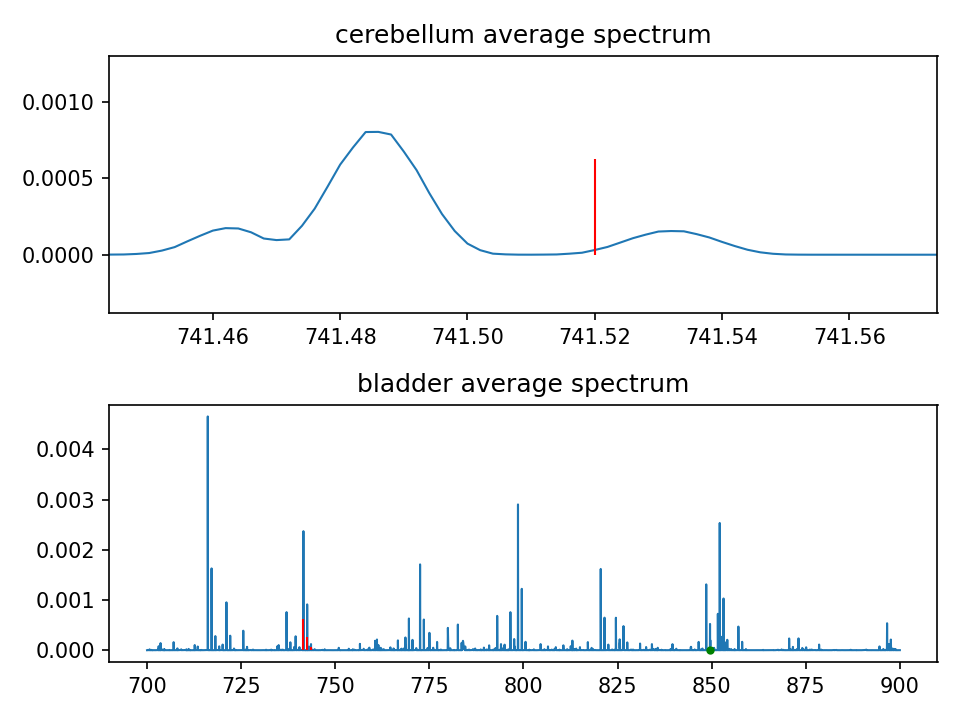

In [165]:
plt.figure()
for i, n in enumerate(names):
    plt.subplot(211+i)
    plt.title(n + ' average spectrum')
    profile_average_spectra[n].plot(profile=True)
    (spectrum_hidden_in_bladder*0.001).plot(color='red')
    plt.plot(spectrum_hidden_in_cerebellum.confs[0][0], [0], 'g.')
plt.tight_layout()

Oznaczyć kolorami wspólne i charakterystyczne dla strategii. Porównać na widmie profilowym.  
Zrobić obrazki dla wszystkich charakterystycznych. Wybrać piksele o dużej intensywności i zrobić widma średnie, nałożyć na nie widmo teoretyczne i zobaczyć czy piki się zgadzają, zwłaszcza jeśli z average wydaje się, że nie 

In [141]:
hidden_mass_in_bladder = 741.52
closest_average_peak_in_bladder = 741.54

In [143]:
# hidden_mass_in_bladder = 849.625
# closest_average_peak_in_bladder = 849.56

In [168]:
hidden_mass_in_cerebellum = 741.52
closest_average_peak_in_cerebellum = 740.48

In [159]:
# hidden_mass_in_cerebellum = 849.62
# closest_average_peak_in_cerebellum = 849.64

In [160]:
# hidden_mass_in_cerebellum = 846.542
# closest_average_peak_in_cerebellum = 846.532

In [161]:
# hidden_mass_in_cerebellum = 745.478
# closest_average_peak_in_cerebellum = 745.495  # not from average, but from another lipid

<IPython.core.display.Javascript object>


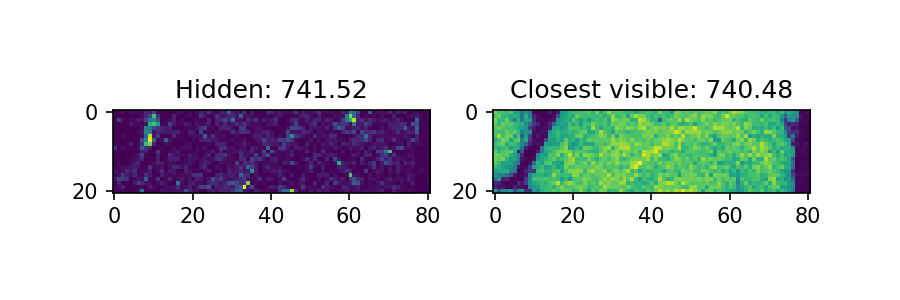

Text(0.5, 1.0, 'Closest visible: 740.48')

In [169]:
hidden_image = profile_ion_image(cerebellum_profile_image, hidden_mass_in_cerebellum)
closest_image = profile_ion_image(cerebellum_profile_image, closest_average_peak_in_cerebellum)
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.imshow(hidden_image)
plt.title('Hidden: %.2f' % hidden_mass_in_cerebellum)
plt.subplot(122)
plt.imshow(closest_image)
plt.title('Closest visible: %.2f' % closest_average_peak_in_cerebellum)

<IPython.core.display.Javascript object>


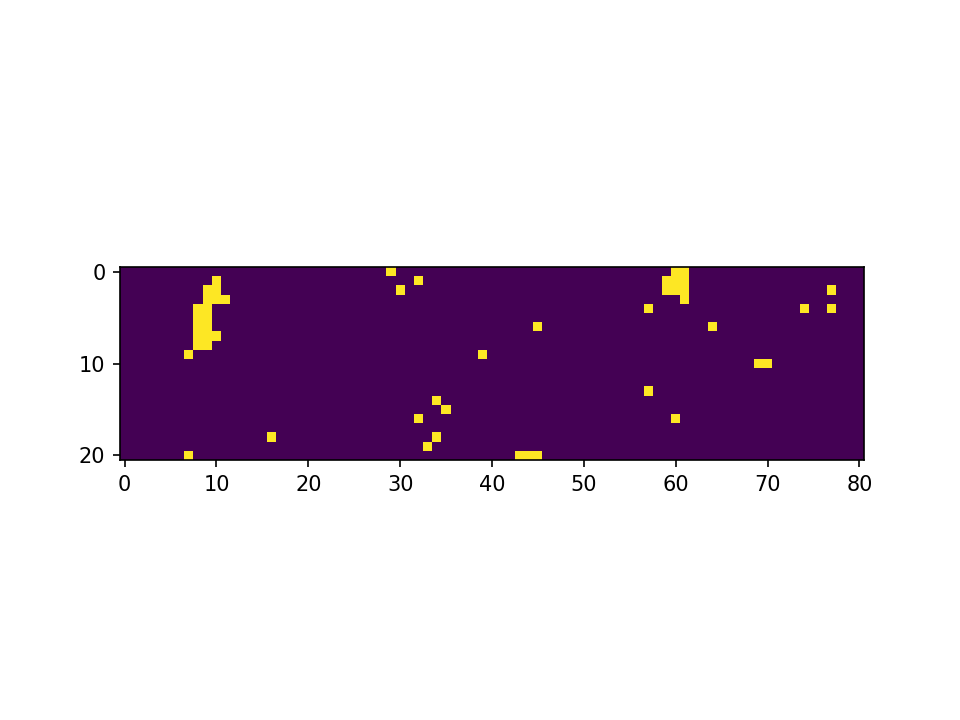

In [173]:
plt.figure()
plt.imshow(hidden_image > 0.05)

<IPython.core.display.Javascript object>


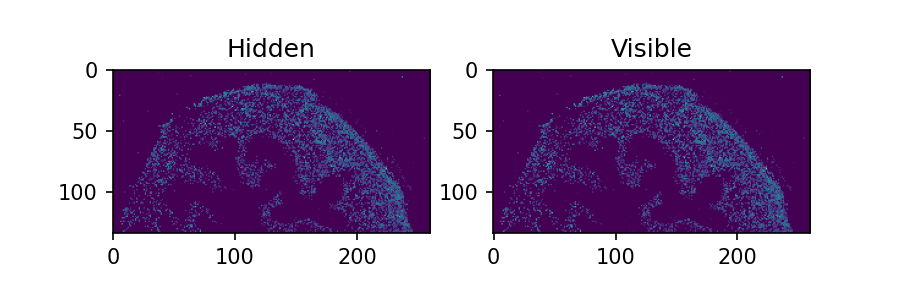

Text(0.5, 1.0, 'Visible')

In [146]:
hidden_image = profile_ion_image(bladder_profile_image, hidden_mass_in_bladder)
closest_image = profile_ion_image(bladder_profile_image, closest_average_peak_in_bladder)
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.imshow(hidden_image)
plt.title('Hidden')
plt.subplot(122)
plt.imshow(closest_image)
plt.title('Visible')

Notka: Obrazki po dekonwolucji nie musza byc ladne, interesuje nas jedynie istnienie ukrytych pikow 

Po segmentacji zrobic porownanie widm w segmentach odpowiadajacych hidden pikom oraz widm srednich